In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'
from orographicPrecipitation.precip_extremes_scaling import scaling

#import metpy.calc as mpcalc
#from metpy.plots import SkewT
#from metpy.units import units
import wrf
from netCDF4 import Dataset

# Functions, data

In [2]:
def extract_wrfout(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfpro(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfpout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

In [3]:
drychannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel_dry.wrf.100x10.mountain.100km.180d/')

In [4]:
drychannel2 = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel_dry2.wrf.100x10.mountain.100km.180d/')

In [5]:
dryhrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/')

In [6]:
hrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')

In [7]:
hgt = drychannel.HGT.isel(south_north=0,Time=-1).persist()
hrhgt = dryhrchannel.HGT.isel(south_north=0,Time=-1).persist()
def plotsection(hgt):
    fig, ax = plt.subplots(1,1,figsize=(15,4))
    ax.set_xlabel("distance west of mountain top (km)")
    ax.set_ylabel("height(m)")
    ax.plot((50-hgt.west_east)*100,hgt,color='k')
    return ax,ax.twinx()

In [8]:
def add_text(ax):
    ax.text(0.1, 0.1,'EAST (upstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")
    ax.text(0.9, 0.1,'WEST (downstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")

# Low res

## Temperature soundings

In [15]:
sigma = drychannel.ZNU.isel(Time=-1)

Text(0.5, 1.0, 'domain-mean potential temperature')

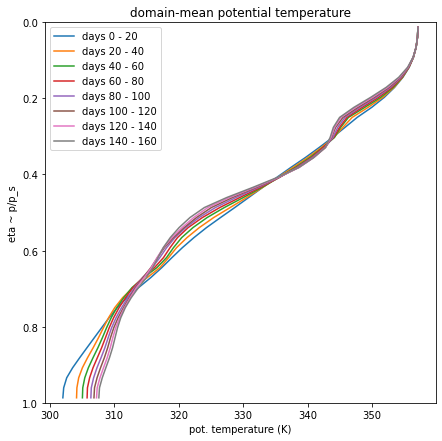

In [44]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

n=20
for i in range(8):
    ax.plot(300+drychannel.T.isel(Time=slice(4*n*i,4*n*(i+1))).mean(['Time','south_north','west_east']),sigma,label='days %i - %i'%(n*i,n*(i+1)))
ax.legend()
ax.set_xlabel('pot. temperature (K)')
ax.set_ylabel('eta ~ p/p_s')
ax.set_ylim(1,0)
ax.set_title('domain-mean potential temperature')


Text(0.5, 1.0, 'domain-mean potential temperature')

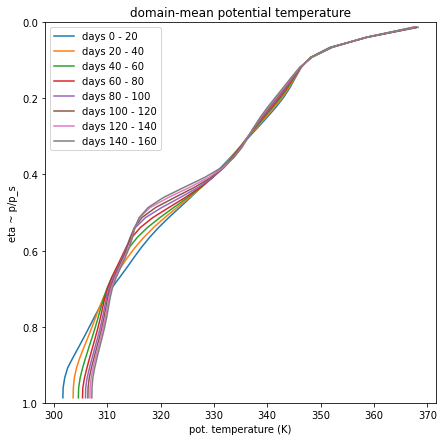

In [16]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

n=20
for i in range(8):
    ax.plot(300+drychannel2.T.isel(Time=slice(4*n*i,4*n*(i+1))).mean(['Time','south_north','west_east']),sigma,label='days %i - %i'%(n*i,n*(i+1)))
ax.legend()
ax.set_xlabel('pot. temperature (K)')
ax.set_ylabel('eta ~ p/p_s')
ax.set_ylim(1,0)
ax.set_title('domain-mean potential temperature')


In [23]:
np.array(hgt)[50]

1000.0

Text(0.5, 1.0, 'Evaporation')

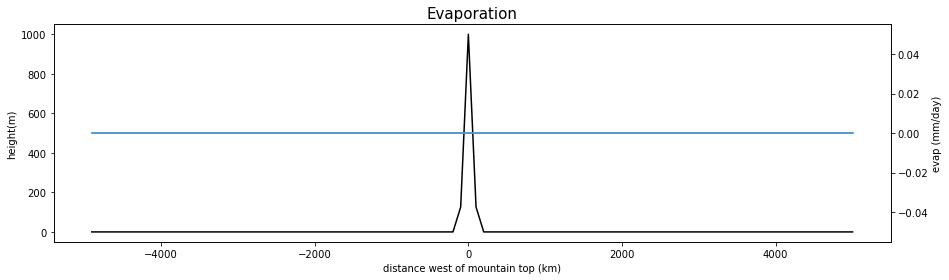

In [27]:
_,ax2 = plotsection(hgt)
dist=(50-hgt.west_east)*100
ax2.set_ylabel("evap (mm/day)")
ax2.plot(dist,drychannel.HFX.isel(Time=slice(200,400)).mean(['south_north','Time']),color='orange')
ax2.plot(dist,drychannel.LH.isel(Time=slice(200,400)).mean(['south_north','Time']),color='dodgerblue')

ax2.set_title("Evaporation", fontsize=15)


Text(0.5, 1.0, 'Evaporation')

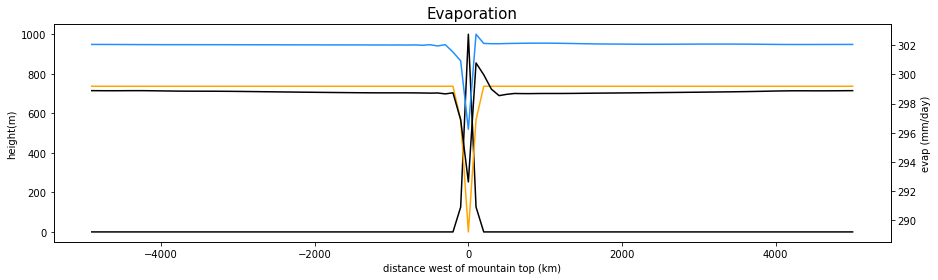

In [12]:
_,ax2 = plotsection(hgt)
dist=(50-hgt.west_east)*100
ax2.set_ylabel("evap (mm/day)")
ax2.plot(dist,drychannel.SST.isel(Time=slice(200,400)).mean(['south_north','Time']),color='orange')
ax2.plot(dist,drychannel.T2.isel(Time=slice(200,400)).mean(['south_north','Time']),color='dodgerblue')
ax2.plot(dist,drychannel.T2.isel(Time=slice(1,2)).mean(['south_north','Time']),color='k')

ax2.set_title("Evaporation", fontsize=15)


## Winds, days 50-100

In [67]:
hgt.isel(west_east=50).load()

<xarray.DataArray 'HGT' ()>
array(1000., dtype=float32)
Coordinates:
    XLAT     float32 10.0
    XLONG    float32 50.0
    XTIME    datetime64[ns] 1970-06-30
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  Terrain Height
    units:        m
    stagger:

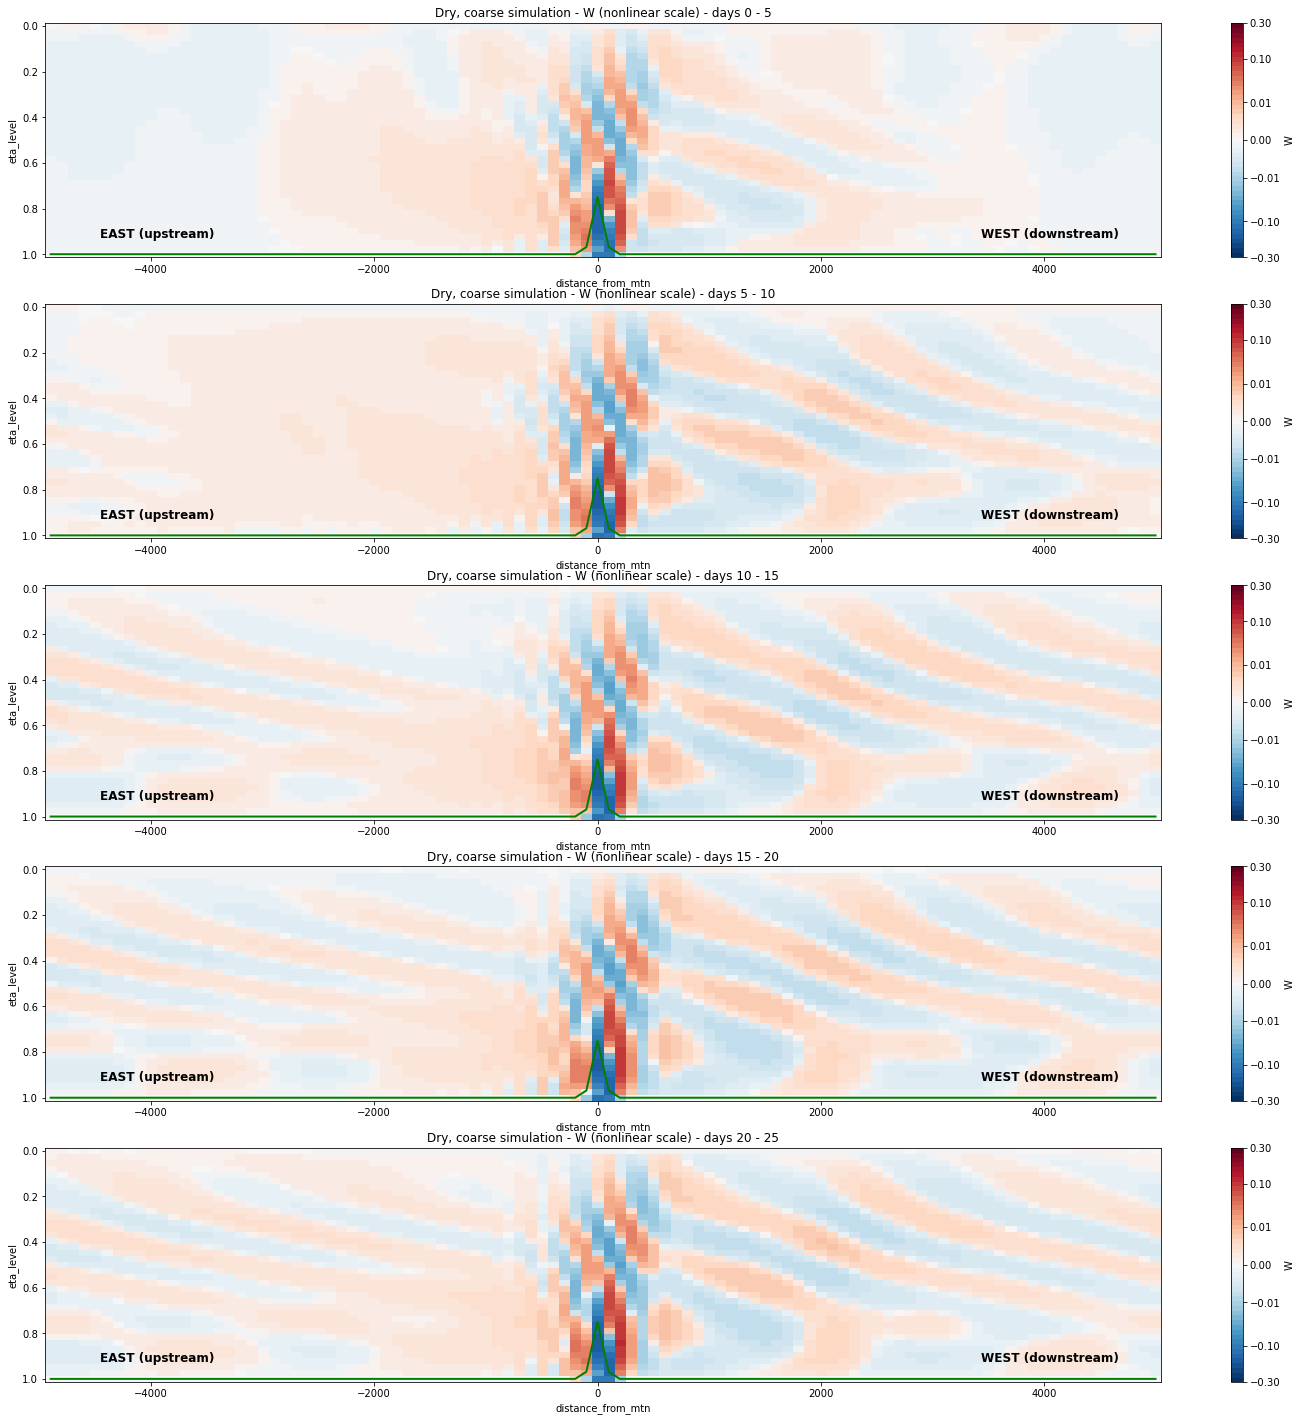

In [19]:
w_plot_allt = drychannel2.W.mean("south_north").assign_coords({'distance_from_mtn':(50-hgt.west_east)*100,'eta_level':drychannel2.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()

_,axx=plt.subplots(5,1,figsize=(25,25))

n=5
for i in range(5):
    ax=axx[i]
    w_plot_allt.isel(Time=slice(4*i*n,4*(i+1)*n)).mean('Time').plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
    ax.plot(w_plot_allt.distance_from_mtn, 1-hgt/4000,color='g',linewidth=2)
    add_text(ax)
    ax.set_title("Dry, coarse simulation - W (nonlinear scale) - days %i - %i"%(i*n,(i+1)*n))

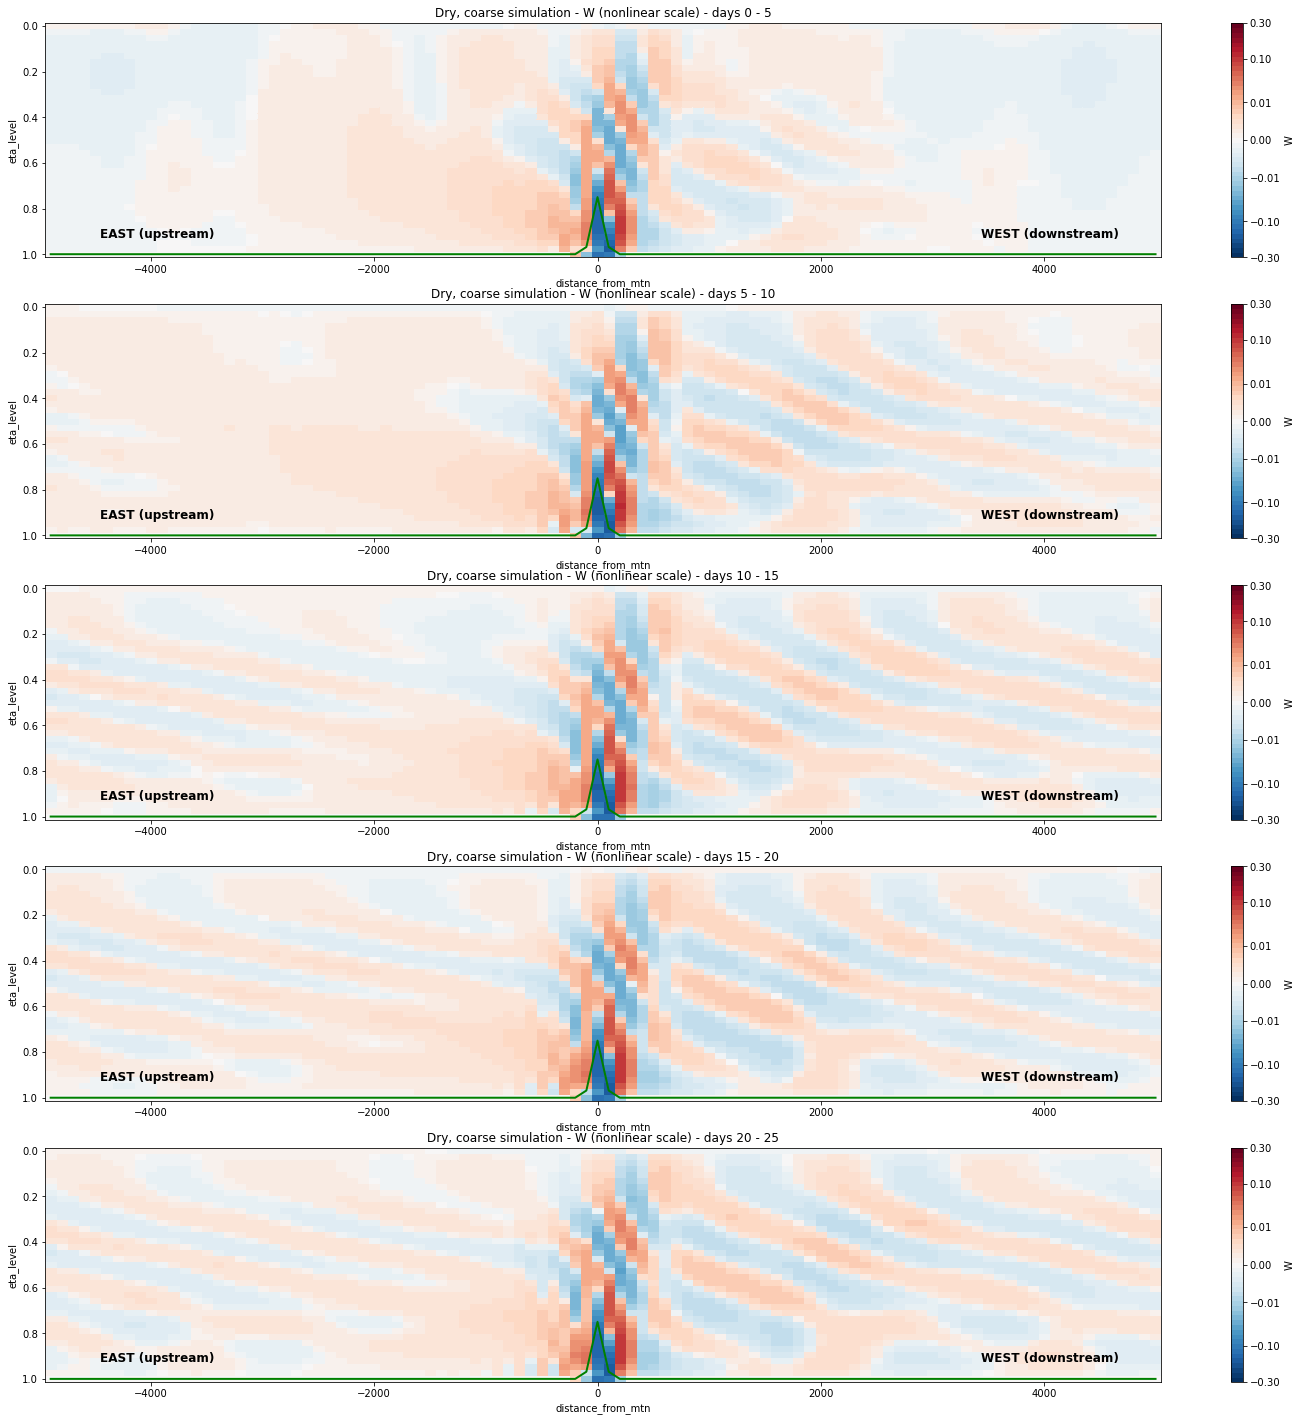

In [68]:
w_plot_allt = drychannel.W.mean("south_north").assign_coords({'distance_from_mtn':(50-hgt.west_east)*100,'eta_level':drychannel.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()

_,axx=plt.subplots(5,1,figsize=(25,25))

n=5
for i in range(5):
    ax=axx[i]
    w_plot_allt.isel(Time=slice(4*i*n,4*(i+1)*n)).mean('Time').plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
    ax.plot(w_plot.distance_from_mtn, 1-hgt/4000,color='g',linewidth=2)
    add_text(ax)
    ax.set_title("Dry, coarse simulation - W (nonlinear scale) - days %i - %i"%(i*n,(i+1)*n))

In [41]:
%%time
u = drychannel.U.isel(Time=slice(200,720)).mean(["Time","south_north"]).persist()
v = drychannel.V.isel(Time=slice(200,720)).mean(["Time","south_north_stag"]).persist()
w = drychannel.W.isel(Time=slice(200,720)).mean(["Time","south_north"]).persist()

CPU times: user 363 ms, sys: 1.91 s, total: 2.27 s
Wall time: 3.68 s


In [49]:
w_plot=w.assign_coords({'distance_from_mtn':(50-hgt.west_east)*100,'eta_level':drychannel.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'})

Text(0.5, 1.0, 'Dry, coarse simulation - W (nonlinear scale)')

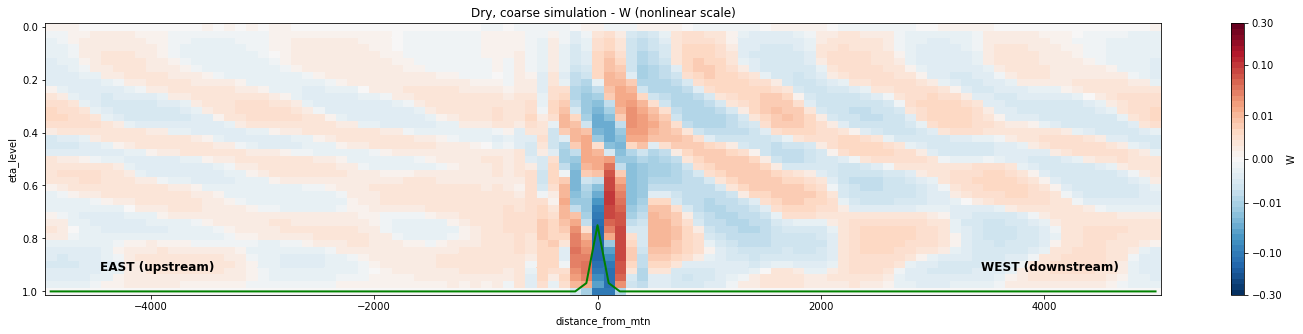

In [59]:
_,ax=plt.subplots(1,1,figsize=(25,5))
w_plot.plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(w_plot.distance_from_mtn, 1-hgt/4000,color='g',linewidth=2)
add_text(ax)
ax.set_title("Dry, coarse simulation - W (nonlinear scale)")


Text(0.5, 1.0, 'Fully interactive high res simulation - V')

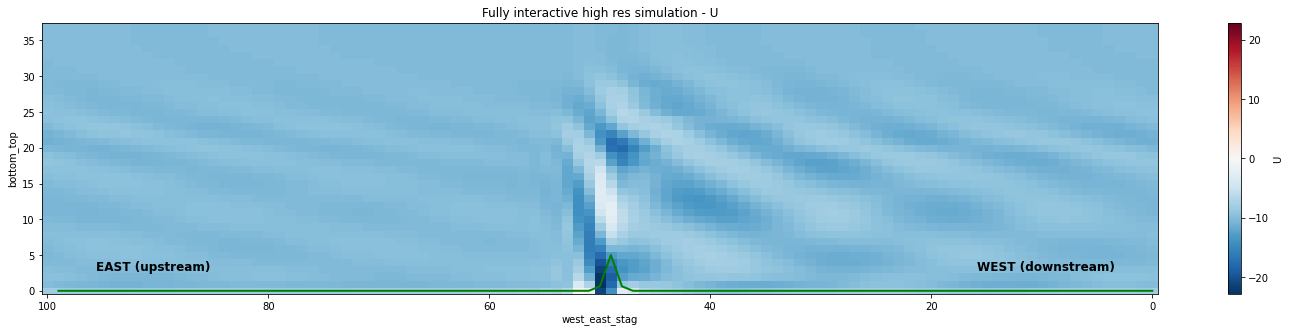

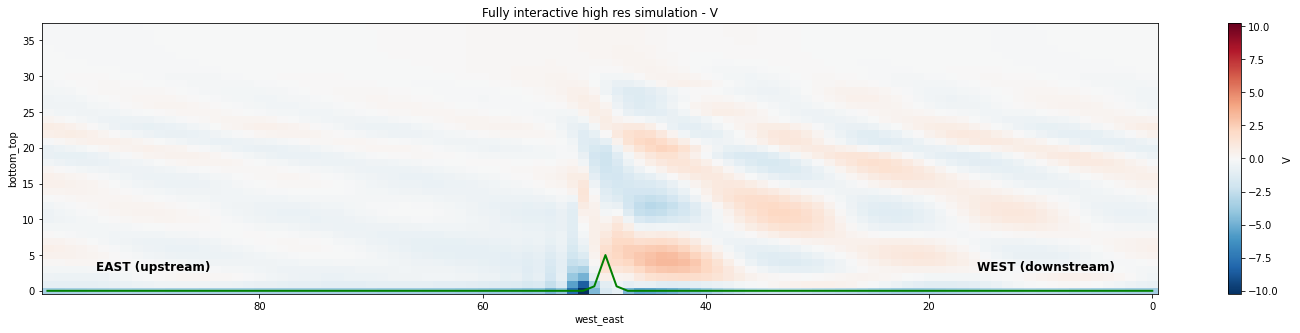

In [43]:
_,ax=plt.subplots(1,1,figsize=(25,5))
u.plot(ax=ax, x='west_east_stag',xincrease=False)#, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hrchannel.west_east, hgt[::-1]/200,color='g',linewidth=2)
add_text(ax)
ax.set_title("Fully interactive high res simulation - U")

_,ax=plt.subplots(1,1,figsize=(25,5))
v.plot(ax=ax, x='west_east',xincrease=False)#, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hrchannel.west_east, hgt[::-1]/200,color='g',linewidth=2)
add_text(ax)
ax.set_title("Fully interactive high res simulation - V")


# High res

## Soundings

In [9]:
sigma = dryhrchannel.ZNU.isel(Time=-1)

Text(0.5, 1.0, 'domain-mean potential temperature')

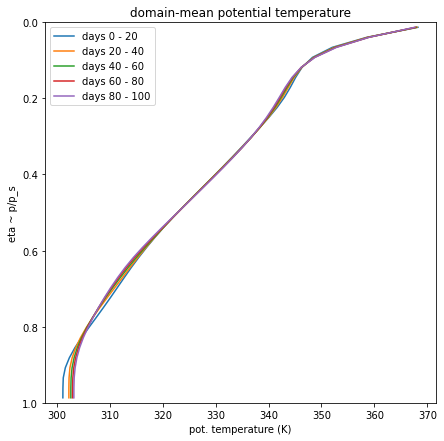

In [10]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

n=20
for i in range(5):
    ax.plot(300+dryhrchannel.T.isel(Time=slice(4*n*i,4*n*(i+1))).mean(['Time','south_north','west_east']),sigma,label='days %i - %i'%(n*i,n*(i+1)))
ax.legend()
ax.set_xlabel('pot. temperature (K)')
ax.set_ylabel('eta ~ p/p_s')
ax.set_ylim(1,0)
ax.set_title('domain-mean potential temperature')


## Winds

In [11]:
hrhgt = dryhrchannel.HGT.isel(south_north=0,Time=-1).persist()

CPU times: user 15.7 s, sys: 18.4 s, total: 34.1 s
Wall time: 33.6 s


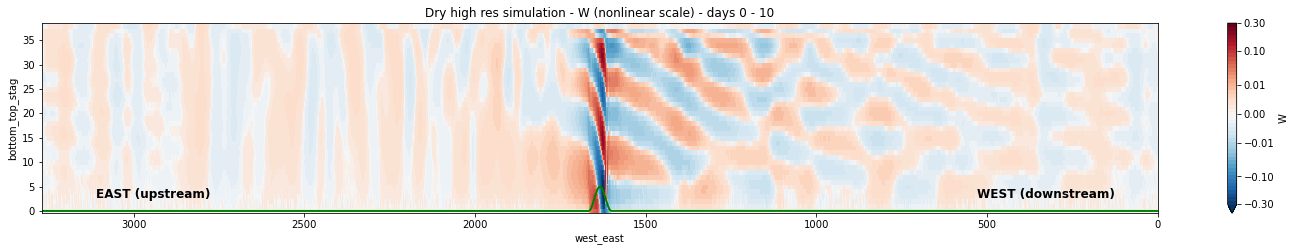

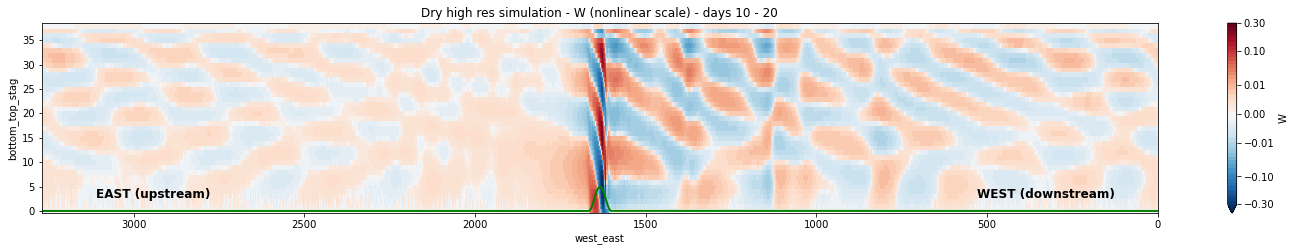

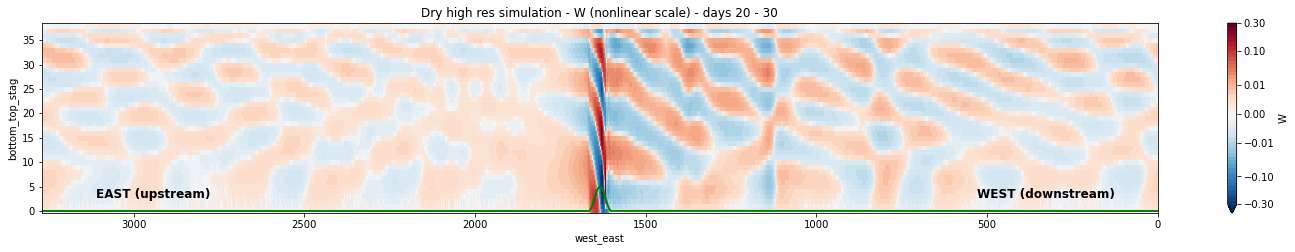

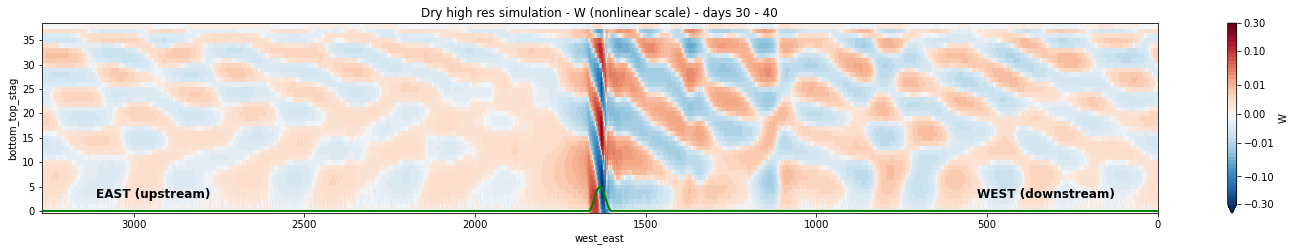

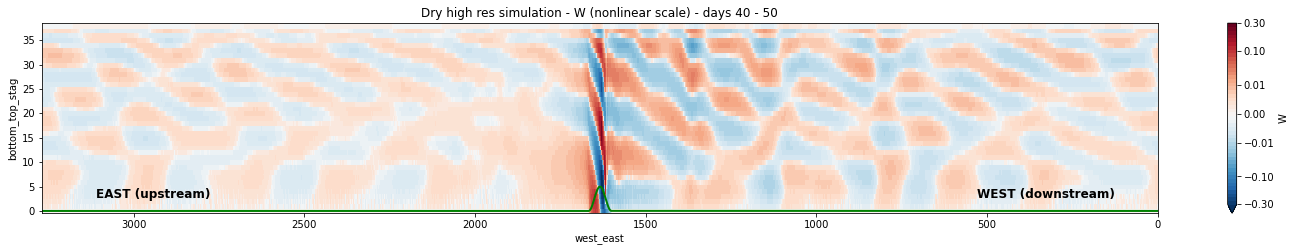

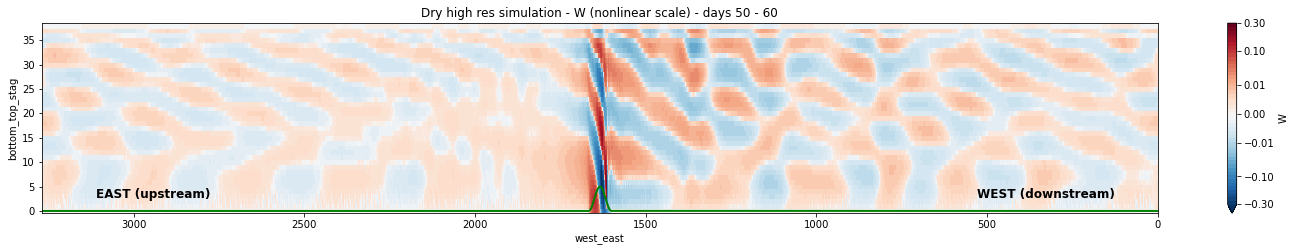

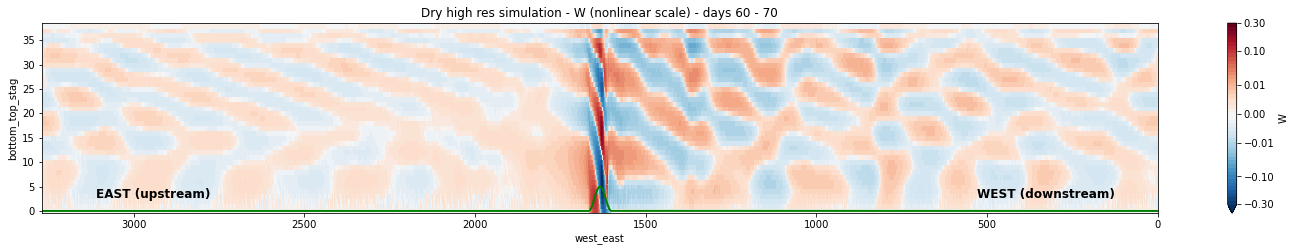

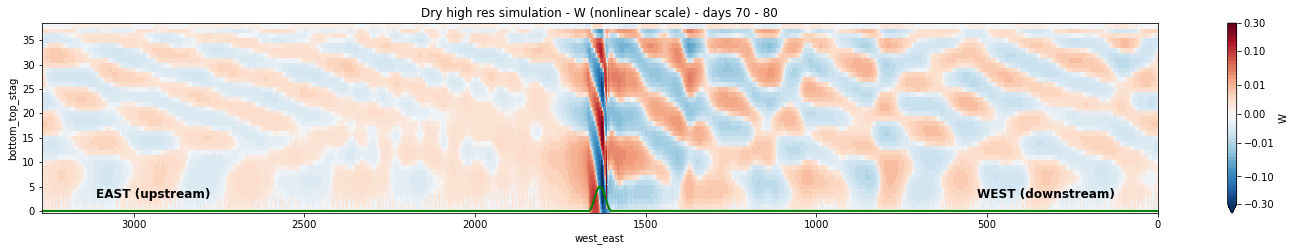

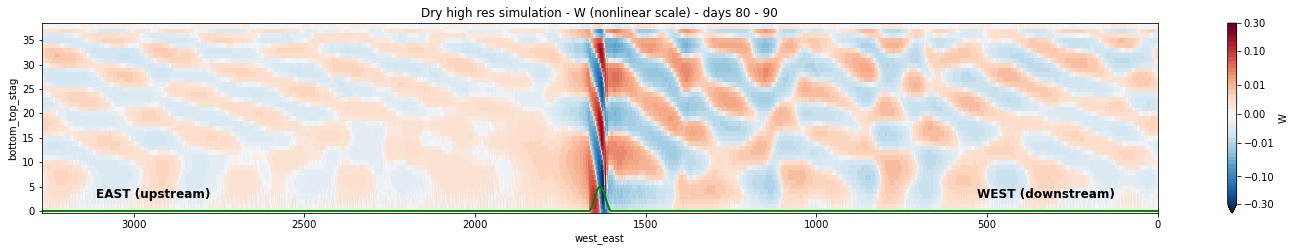

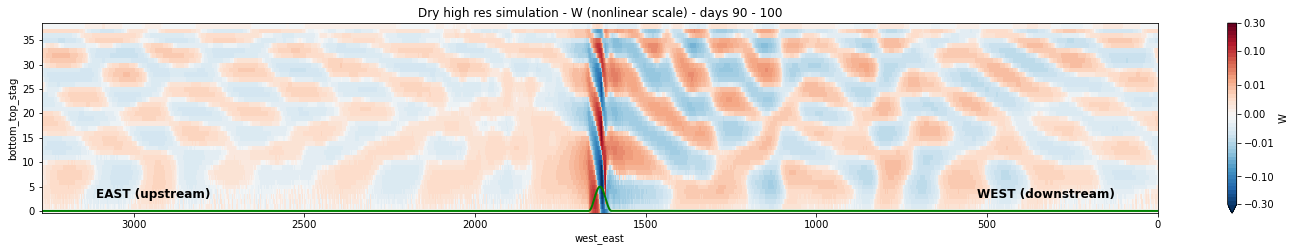

In [15]:
%%time
w_spinup=[]
n=10
p=10
for i in range(p):
    w_spinup.append(dryhrchannel.W.isel(Time=slice(n*4*i,n*4*(i+1))).mean(["Time","south_north"]).persist())
    _,ax=plt.subplots(1,1,figsize=(25,3.5))
    w_spinup[-1].plot(ax=ax, x='west_east',xincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
    ax.plot(dryhrchannel.west_east, hrhgt[::-1]/200,color='g',linewidth=2)
    add_text(ax)
    ax.set_title("Dry high res simulation - W (nonlinear scale) - days %i - %i"%(n*i,n*(i+1)))

In [13]:
%%time
w_moist= xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W.days50-200.nc")
w_dry  = dryhrchannel.W.isel(Time=slice(200,401)).mean(["Time","south_north"]).persist()

CPU times: user 8.09 s, sys: 16.8 s, total: 24.8 s
Wall time: 22.5 s


In [14]:
w_dry.to_netcdf("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W.days50-100.nc")

In [18]:
wrol = w_moist.rolling(west_east=101, center=True).mean()

In [19]:
wrol_50to100 = hrchannel.W.isel(Time=slice(200,401)).mean(["Time","south_north"]).rolling(west_east=101, center=True).mean().persist()

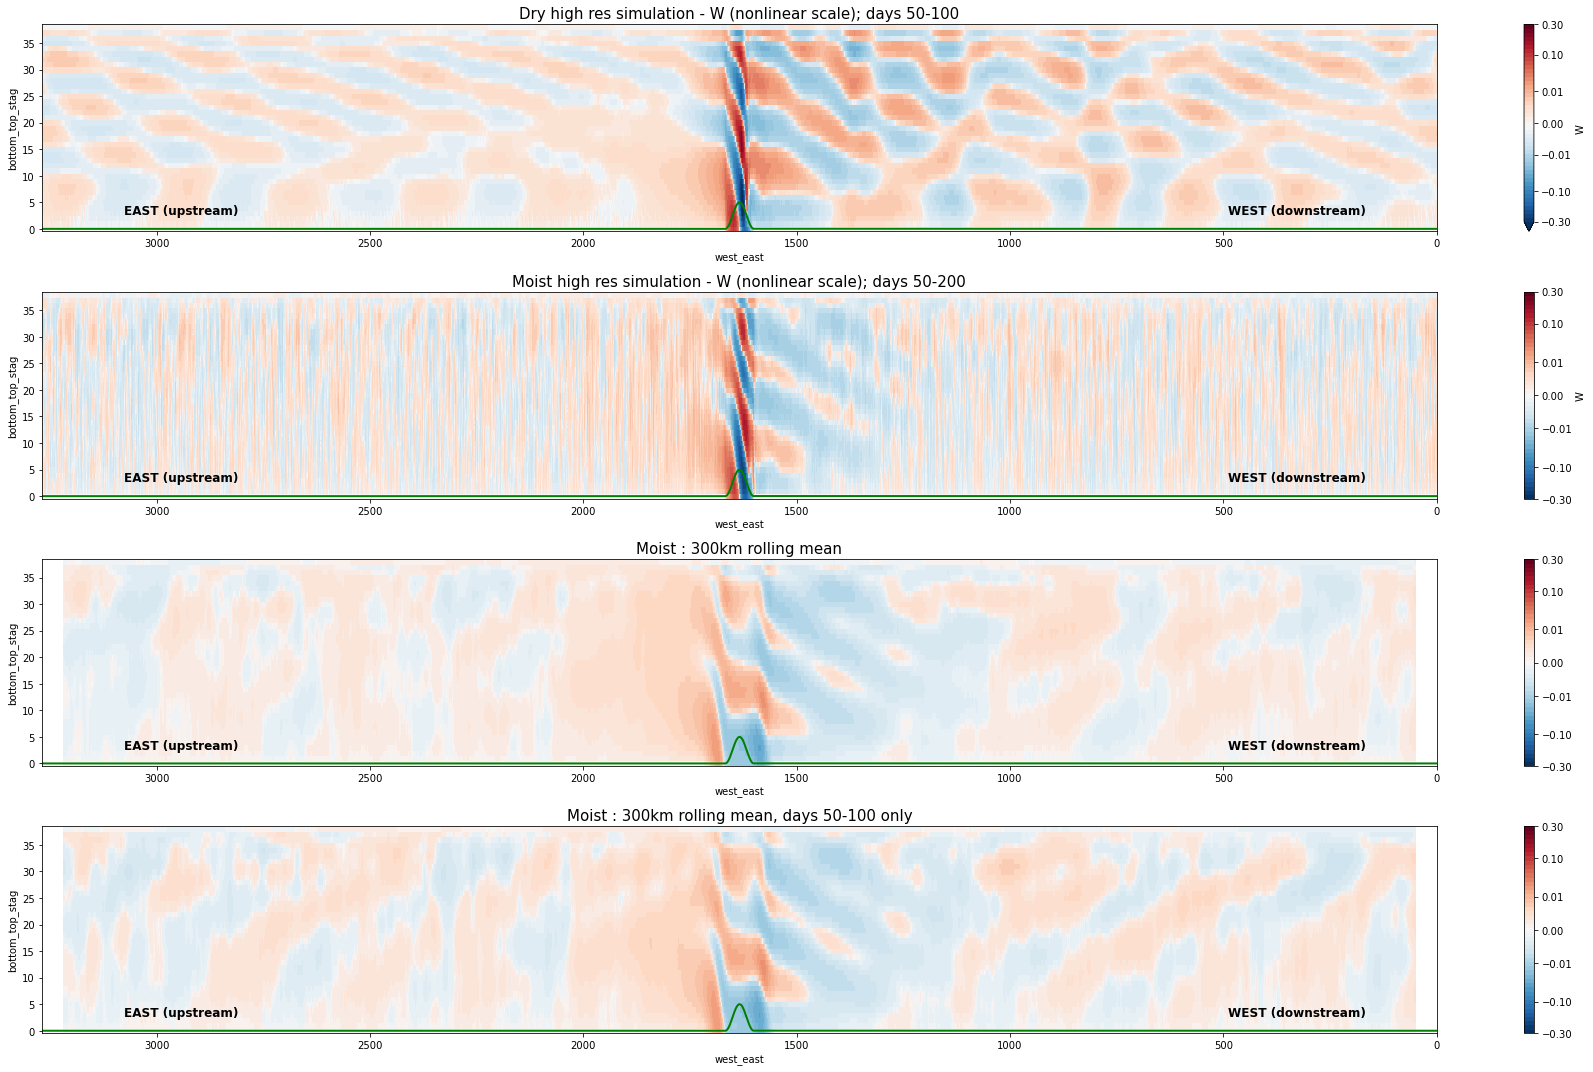

In [23]:

fig,ax=plt.subplots(4,1,figsize=(25,15))
w_dry.plot(ax=ax[0], x='west_east',xincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
w_moist.plot(ax=ax[1], x='west_east',xincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
wrol.plot(ax=ax[2], x='west_east',xincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
wrol_50to100.plot(ax=ax[3], x='west_east',xincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})




for a in ax:
    a.plot(dryhrchannel.west_east, hrhgt[::-1]/200,color='g',linewidth=2)
    add_text(a)
    
ax[0].set_title("Dry high res simulation - W (nonlinear scale); days 50-100", fontsize=15)
ax[1].set_title("Moist high res simulation - W (nonlinear scale); days 50-200", fontsize=15)
ax[2].set_title("Moist : 300km rolling mean", fontsize=15)
ax[3].set_title("Moist : 300km rolling mean, days 50-100 only", fontsize=15)
fig.tight_layout()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/plot/plot.py:934: UserWarning: The following kwargs were not used by contour: 'color'
  primitive = ax.contour(x, y, z, **kwargs)


Text(0.5, 1.0, 'Moist high res simulation - W (nonlinear scale); days 50-200 || CONTOURS : w_dry=0')

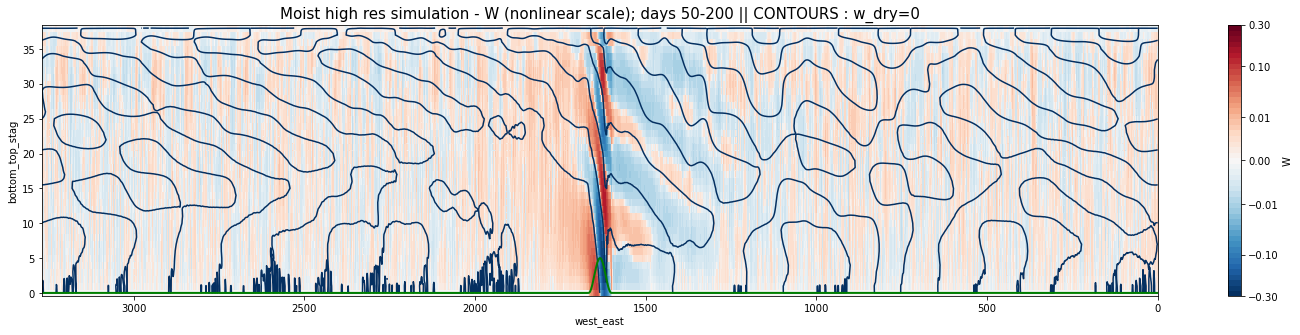

In [25]:

fig,ax=plt.subplots(1,1,figsize=(25,5))
w_dry.plot.contour(ax=ax, x='west_east',xincrease=False, levels=[0.],color='k')
w_moist.plot(ax=ax, x='west_east',xincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})

ax.plot(dryhrchannel.west_east, hrhgt[::-1]/200,color='g',linewidth=2)

ax.set_title("Moist high res simulation - W (nonlinear scale); days 50-200 || CONTOURS : w_dry=0", fontsize=15)


# Precip predicted by dry motion VS moist simulation precip

In [90]:
plevs = np.arange(125.,990.,20.)[::-1]
plevs

array([985., 965., 945., 925., 905., 885., 865., 845., 825., 805., 785.,
       765., 745., 725., 705., 685., 665., 645., 625., 605., 585., 565.,
       545., 525., 505., 485., 465., 445., 425., 405., 385., 365., 345.,
       325., 305., 285., 265., 245., 225., 205., 185., 165., 145., 125.])

In [99]:
w_3d=dryhrchannel.W.isel(Time=slice(200,401)).mean("Time").persist()
w_3d = xr.DataArray(wrf.destagger(w_3d,0),coords=dryhrchannel.T.isel(Time=0).coords)
w_3d_p = wrf.vinterp(Dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/wrfout_d01_1970-04-01_06_00_00'),
                     w_3d,"pressure",plevs
                    ).rename({'interp_level':'pressure'}).fillna(0.)
w_dry_p = w_3d_p.mean('south_north')

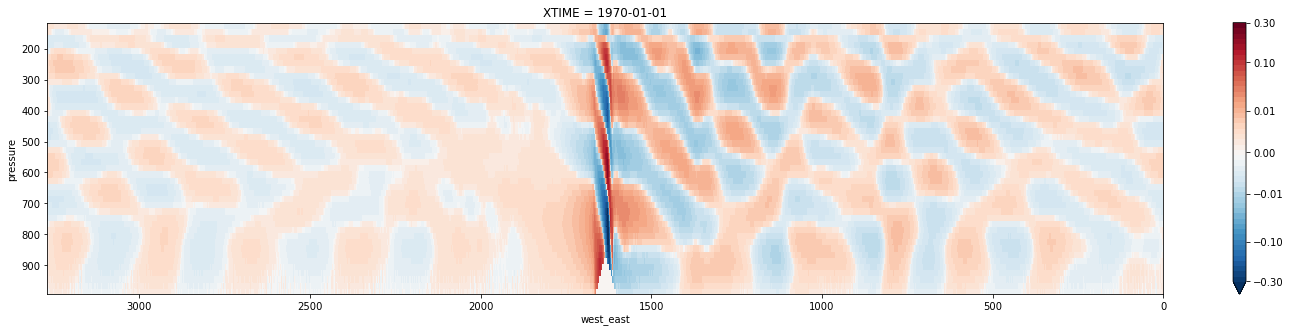

In [100]:
fig,ax=plt.subplots(1,1,figsize=(25,5))
w_dry_p.plot(ax=ax,xincrease=False,yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})


In [96]:
def interpolate(var):
    var=var.isel(Time=slice(200,401)).mean("Time")
    var_p = wrf.vinterp(Dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/wrfout_d01_1970-04-01_06_00_00'),
                     var,"pressure",plevs
                    ).rename({'interp_level':'pressure'}).fillna(0.)
    return var_p.mean('south_north').persist()

In [105]:
rho_dry_p = interpolate(dryhrchannel.RHO)
Theta_dry_p = interpolate(dryhrchannel.T)

In [114]:
omega_dry_p = -rho_dry_p*9.81*w_dry_p
T_dry_p=(300.+Theta_dry_p)*(Theta_dry_p.pressure/1000)**0.286
ps_dry = dryhrchannel.PSFC.isel(Time=slice(200,401)).mean(['Time','south_north'])

In [124]:
precip = xr.apply_ufunc(scaling,omega_dry_p.load(),T_dry_p.load(),T_dry_p.pressure.load()*100,ps_dry.load(),input_core_dims=[['pressure'], ['pressure'], ['pressure'],[]],vectorize=True)

In [129]:
hrchannel10precip = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc")

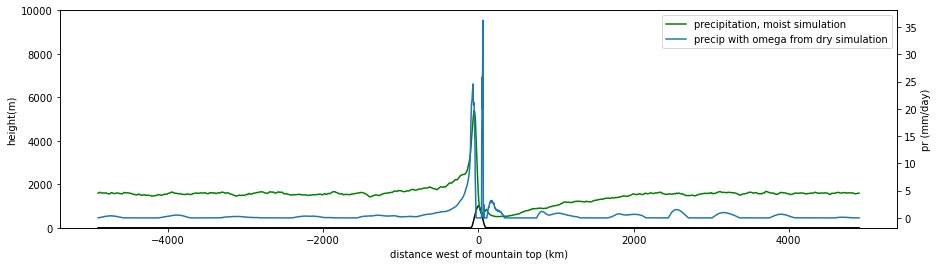

In [133]:
hrhgt = dryhrchannel.HGT.isel(south_north=0,Time=-1).persist()
hrdist=(1635-hrhgt.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.plot(hrdist,hrhgt,color='k')
ax2 = ax.twinx()
ax2.set_ylabel("pr (mm/day)")
ax.set_ylim(0,10000)

ax2.plot(hrdist,hrchannel10precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='green',label='precipitation, moist simulation')
ax2.plot(hrdist,86400*np.maximum(precip,0.),label="precip with omega from dry simulation")

ax2.legend()

In [137]:
from orographicPrecipitation.precip_extremes_scaling import *
def scaling_nonnegative(omega, temp, plev, ps):

    try:
        if plev[0]<plev[1]:
            raise ValueError('unexpected ordering of pressure levels')
    except ValueError:
        raise
        
    # criterion for identifying tropopause
    crit_lapse_rate = 0.002 # (k/m) for tropopause
    plev_mask = 0.05e5 # (Pa) exclude levels above this as a fail-safe

    dqsat_dp, dqsat_dT,_ = sat_deriv(plev, temp)
    es, qsat, rsat, latent_heat = saturation_thermodynamics(temp, plev, 'era')
    lapse_rate = moist_adiabatic_lapse_rate(temp, plev, 'era')

    # virtual temperature
    temp_virtual = temp*(1.0+qsat*(pars('gas_constant_v')/pars('gas_constant')-1.0))

    # density
    rho = plev/pars('gas_constant')/temp_virtual

    dT_dp = lapse_rate/pars('gravity')/rho

    # find derivative of saturation specific humidity with respect to pressure along 
    # a moist adiabat at the given temperature and pressure for each level
    dqsat_dp_total = dqsat_dp+dqsat_dT*dT_dp

    # mask above tropopause using simple lapse rate criterion
    dT_dp_env = np.gradient(temp, plev)
    lapse_rate_env = dT_dp_env*rho*pars('gravity')

    itrop = np.where(lapse_rate_env>crit_lapse_rate)[0]
    if itrop.size!=0:
        if np.max(itrop)+1<len(plev):
            dqsat_dp_total[np.max(itrop)+1:]=0

    # mask above certain level as fail safe
    dqsat_dp_total[plev<plev_mask]=0

    dqsat_dp_total_omega = dqsat_dp_total*omega

    # replaces nans with zeros as subsurface values should not contribute
    # to the column integral
    dqsat_dp_total_omega[np.isnan(dqsat_dp_total_omega)]=0

    # also use surface pressure to zero subsurface values
    kbot = plev>ps
    if any(kbot):
        dqsat_dp_total_omega[kbot]=0
       
    # get rid of negative values
    dqsat_dp_total_omega[dqsat_dp_total_omega>=0.]=0

    # integrate in the vertical
    precip = -integrate(-dqsat_dp_total_omega,plev)/pars('gravity')

    return precip

In [138]:
precip_nn = xr.apply_ufunc(scaling_nonnegative,omega_dry_p.load(),T_dry_p.load(),T_dry_p.pressure.load()*100,ps_dry.load(),input_core_dims=[['pressure'], ['pressure'], ['pressure'],[]],vectorize=True)

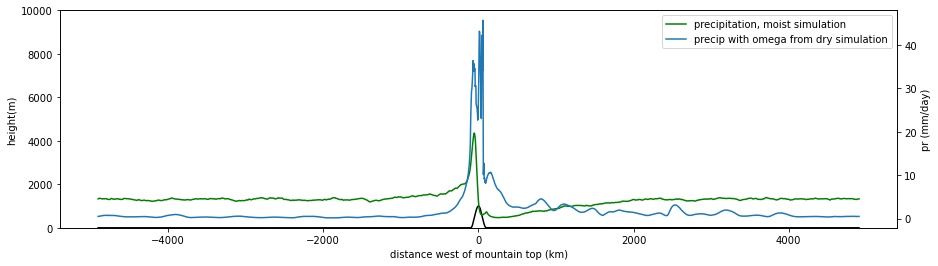

In [139]:
hrhgt = dryhrchannel.HGT.isel(south_north=0,Time=-1).persist()
hrdist=(1635-hrhgt.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.plot(hrdist,hrhgt,color='k')
ax2 = ax.twinx()
ax2.set_ylabel("pr (mm/day)")
ax.set_ylim(0,10000)

ax2.plot(hrdist,hrchannel10precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='green',label='precipitation, moist simulation')
ax2.plot(hrdist,86400*np.maximum(precip_nn,0.),label="precip with omega from dry simulation")

ax2.legend()

# Thermodynamic equation breakdown

## Monthly means, pressure levels

In [11]:
def select_time(ds):
    return ds.isel(Time=slice(200,300))

In [12]:
def interp_pressure(var):
    """var must be destaggered"""
    plevs= np.arange(125.,990.,20.)[::-1]
    return wrf.vinterp(Dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/wrfout_d01_1970-01-01_00_00_00'),
                         var,"pressure",plevs
                        ).rename({'interp_level':'pressure'}).fillna(0.)

In [ ]:
%%time
# Advective term
meandThetadx = interp_pressure(select_time(dryhrchannel.T).mean('Time')).differentiate('west_east')/3000   # in K/meter
meandThetady = interp_pressure(select_time(dryhrchannel.T).mean('Time')).differentiate('south_north')/3000 # in K/meter
meandestag_U = interp_pressure(wrf.destagger(select_time(dryhrchannel.U).mean('Time'),2,meta=True))
meandestag_V = interp_pressure(wrf.destagger(select_time(dryhrchannel.V).mean('Time'),1,meta=True))

meanugradTheta = ((meandestag_U*meandThetadx+meandestag_V*meandThetady)*86400).persist() #in K/day
meanudThetadx = ((meandestag_U*meandThetadx)*86400).persist() #in K/day
meanvdThetady = ((meandestag_V*meandThetady)*86400).persist() #in K/day


In [14]:
%%time
# Adiabatic term
meandestag_W = interp_pressure(wrf.destagger(select_time(dryhrchannel.W).mean('Time'),0,meta=True))
meanRHO = interp_pressure(select_time(dryhrchannel.RHO).mean('Time'))
meandThetadp = interp_pressure(select_time(dryhrchannel.T).mean('Time')).differentiate('pressure')/100.

meanomegadThetadp = (-9.81*meanRHO*meandestag_W*meandThetadp*86400).persist() #in K/day

CPU times: user 24.2 s, sys: 1min 49s, total: 2min 13s
Wall time: 1min 56s


In [15]:
# diabatic heating term
meanQdiab_pi = meanugradTheta + meanomegadThetadp

In [16]:
def dsmean4(ds):
    return -ds.sel(west_east=slice(1500,2000)).fillna(0.).integrate('pressure').mean('south_north')/np.abs(ds.pressure[0]-ds.pressure[-1])

In [17]:
%%time
meanplot2=dsmean4(meanugradTheta).load()
meanplot3=dsmean4(meanomegadThetadp ).load()
meanplot5=dsmean4(meanQdiab_pi  ).load()

CPU times: user 47.5 ms, sys: 0 ns, total: 47.5 ms
Wall time: 46.6 ms


In [17]:
adiab_dry=dsmean4(meanomegadThetadp ).load()

(-40.0, 40.0)

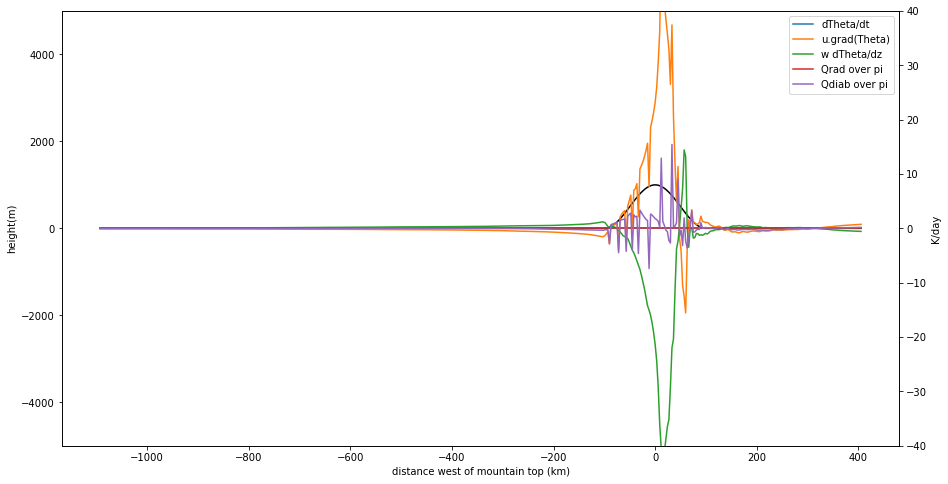

In [18]:
dist=(135-meanplot2.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-5000,5000)
ax.plot(dist,hrhgt[1500:2000],color='k')
ax2=ax.twinx()

ax2.set_ylabel("K/day")
ax2.plot(dist, [0.]*len(dist) ,label="dTheta/dt")
ax2.plot(dist, meanplot2 ,label="u.grad(Theta)")
ax2.plot(dist, meanplot3 ,label="w dTheta/dz")
ax2.plot(dist, [0.]*len(dist) ,label="Qrad over pi")
ax2.plot(dist, meanplot5 ,label="Qdiab over pi")
ax2.legend()
ax2.set_ylim(-40,40)

## Dry vs moist

In [18]:
%%time
# Adiabatic term
meandestag_W_m = interp_pressure(wrf.destagger(select_time(hrchannel.W).mean('Time'),0,meta=True))
meanRHO_m = interp_pressure(select_time(hrchannel.RHO).mean('Time'))
meandThetadp_m = interp_pressure(select_time(hrchannel.T).mean('Time')).differentiate('pressure')/100.

meanomegadThetadp_m = (-9.81*meanRHO_m*meandestag_W_m*meandThetadp_m*86400).persist() #in K/day

CPU times: user 23.5 s, sys: 1min 8s, total: 1min 31s
Wall time: 1min 23s


In [19]:
%%time
adiab_moist=dsmean4(meanomegadThetadp_m).load()

CPU times: user 19.8 ms, sys: 0 ns, total: 19.8 ms
Wall time: 18.1 ms


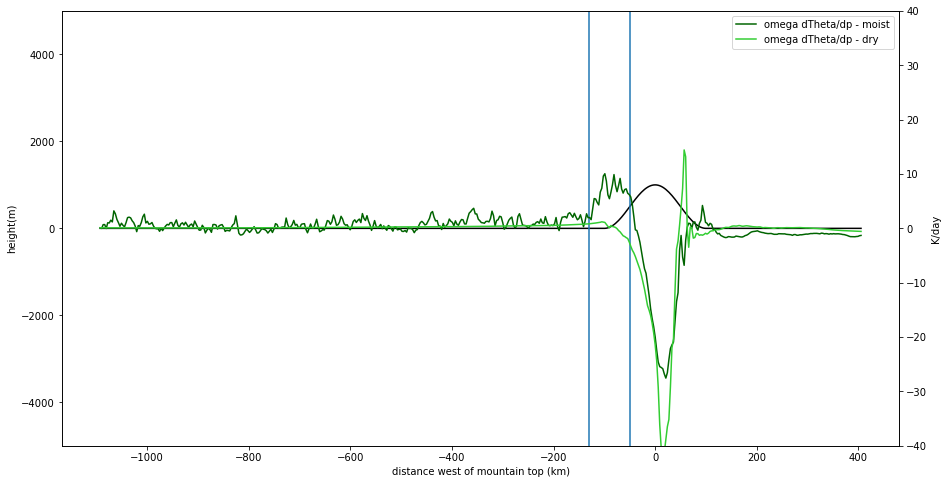

In [45]:
dist=(135-meanplot2.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-5000,5000)
ax.plot(dist,hrhgt[1500:2000],color='k')
ax2=ax.twinx()

ax2.set_ylabel("K/day")
ax2.plot(dist, adiab_moist ,label="omega dTheta/dp - moist", color='darkgreen')
ax2.plot(dist, adiab_dry   ,label="omega dTheta/dp - dry"  , color='limegreen')
ax2.legend()
ax2.set_ylim(-40,40)

ax.axvline(-50)
ax.axvline(-130)

(1010.0, 0.0)

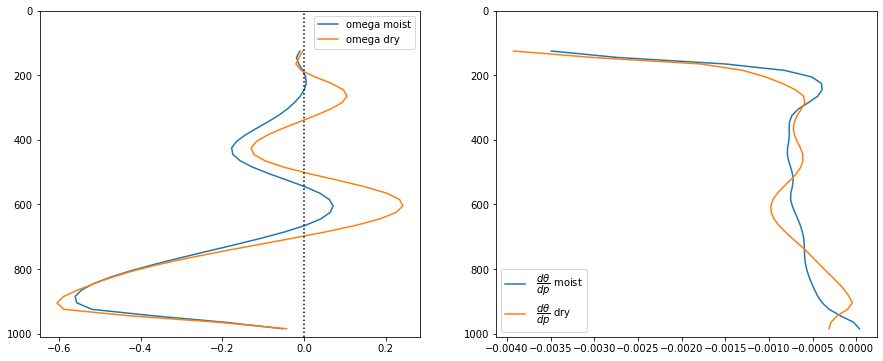

In [53]:
a1 =  1635+50//3
a2 =  1635+130//3
omega_dry = -9.81*meanRHO*meandestag_W
omega_moist = -9.81*meanRHO_m*meandestag_W_m

_,ax=plt.subplots(1,2,figsize=(15,6))
ax[0].plot(omega_moist.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),omega_moist.pressure,label='omega moist')
ax[0].plot(omega_dry.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),omega_dry.pressure,label='omega dry')


ax[1].plot(meandThetadp_m.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),meandThetadp_m.pressure,label=r" $ \dfrac{d\theta}{dp} $ moist")
ax[1].plot(meandThetadp.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),meandThetadp.pressure,label=r" $ \dfrac{d\theta}{dp} $ dry")

ax[0].axvline(0.,color='k',linestyle=':')

ax[0].legend();ax[0].set_ylim(1010,0)
ax[1].legend();ax[1].set_ylim(1010,0)

(1010.0, 0.0)

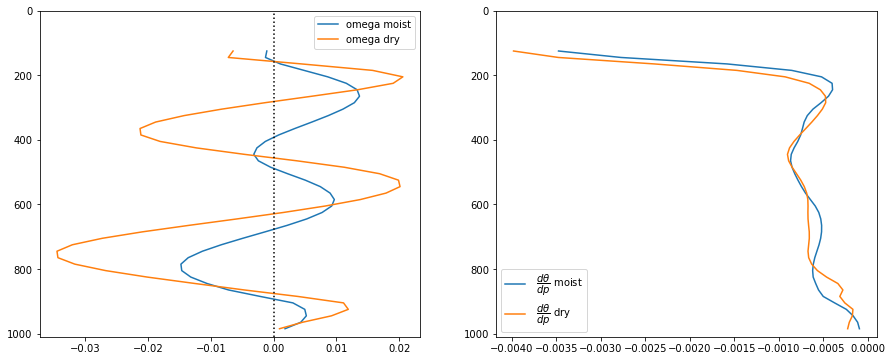

In [56]:
a1 =  1600
a2 =  1675
omega_dry   = meandestag_W  #-9.81*meanRHO*meandestag_W
omega_moist = meandestag_W_m#-9.81*meanRHO_m*meandestag_W_m

_,ax=plt.subplots(1,2,figsize=(15,6))
ax[0].plot(omega_moist.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),omega_moist.pressure,label='omega moist')
ax[0].plot(omega_dry.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),omega_dry.pressure,label='omega dry')


ax[1].plot(meandThetadp_m.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),meandThetadp_m.pressure,label=r" $ \dfrac{d\theta}{dp} $ moist")
ax[1].plot(meandThetadp.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),meandThetadp.pressure,label=r" $ \dfrac{d\theta}{dp} $ dry")

ax[0].axvline(0.,color='k',linestyle=':')

ax[0].legend();ax[0].set_ylim(1010,0)
ax[1].legend();ax[1].set_ylim(1010,0)

In [26]:
a1 =  1600
a2 =  1675
wdrytest   = select_time(dryhrchannel.W).sel(west_east=slice(a1,a2)).mean(['south_north','west_east','Time']).persist()
wmoisttest =    select_time(hrchannel.W).sel(west_east=slice(a1,a2)).mean(['south_north','west_east','Time']).persist()

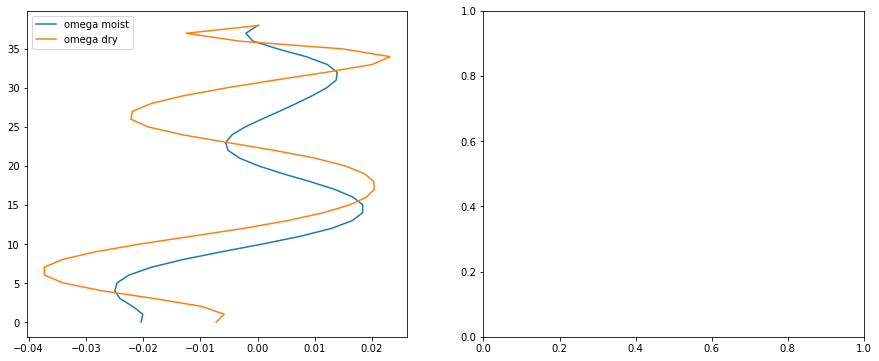

In [27]:

_,ax=plt.subplots(1,2,figsize=(15,6))
ax[0].plot(wmoisttest,range(len(wdrytest  )),label='omega moist')
ax[0].plot(wdrytest  ,range(len(wmoisttest)),label='omega dry')

ax[0].legend()